In [210]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *          

In [211]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import model_selection

# Regularization


We just saw how cross-validation can help find a dimension for a fitted model that balances under- and over-fitting. Rather than selecting the dimension of the model, we can instead, build a model with all of the features, but restrict the size of the coefficients. We keep from over-fitting by adding to the MSE a penalty term on the size of the coefficients. The penalty, called a *regularization term*, is $ \lambda \sum_{j = 1}^{p} \theta_j^2 $. We fit the model by minimizing the combination of mean squared error plus this penalty:

$$
\frac{1}{n} \sum_{i=1}^{n}(y_i - \mathbf{x}_i \boldsymbol{\theta})^2  ~+~ \lambda \sum_{j = 1}^{p} \theta_j^2.
$$

When the *regularization parameter*, $\lambda$, is large, it penalizes large coefficients.
(We typically choose it by cross validation.) 

Penalizing the square of the coefficients, is called $ L_2 $ regularization, or *ridge regression*. Another popular regularization penalizes the absolute size of the coefficients. 

$$
\begin{aligned}
\frac{1}{n} \sum_{i=1}^{n}(y_i - \mathbf{x}_i \boldsymbol{\theta})^2  ~+~ \lambda \sum_{j = 1}^{p} |\theta_j|
\end{aligned}
$$

This  $ L_1 $ regularized linear model is also called *lasso regression* (lasso stands for Least Absolute Shrinkage and Selection Operator).

To get an idea about how regularization works, let's think about the extreme cases: when $ \lambda $ is really large and when it's close to 0 ($ \lambda $ is never negative). With a big regularization parameter, the coefficients are heavily penalized so they shrink. On the other hand, when $ \lambda $ is tiny, then the coefficients aren't restricted. In fact, when $ \lambda $ is 0,  we're back in the world of ordinary least squares. A couple of issues crop up when we think about controlling the size of the coefficients through regularization. 
 
+ We do not want to regularize the intercept term. This way, a large penalty fits a constant model.
+ When features have very different scales, the penalty can impact them differently, with large-valued features being penalized more than others. To avoid this, we standardize all of the features to have mean 0 and variance 1 before fitting the model.


Let's look at an example with 35 features.

## Example: A Market Analysis

A [market research project](https://doi.org/10.1080/02664763.2014.994480) for a pharmaceutical company wants to model consumer interest in purchasing a cold sore healthcare product. They gather data from 1023 consumers. Each consumer is asked to rate on a 10-point scale 35 factors according to whether the factor matters to them when considering purchasing a cold sore treatment. They also rate their interest in purchasing the product.[^Lipovetsky] 

[^Lipovetsky]: Lipovetsky & Conklin (2015) Predictor relative importance
and matching regression parameters, Journal of Applied Statistics, 42:5, 1017-1031.

We begin by reading in the data:

In [212]:
ma_df = pd.read_csv('data/market-analysis.csv')

{numref}`Table %s <market-codebook>` describes the 35 factors and provides their correlation to the outcome, their interest in purchasing the product. 

:::{table} Codebook
:name: market-codebook


|  | Corr | Description |  | Corr | Description |
| --- | --- | --------- | --- | --- | --------- |
| x1  | 0.70 | provides soothing relief | x19 | 0.54 | has a non-messy application |
| x2  | 0.58 | moisturizes cold sore blister | x20 | 0.70 | good for any stage of a cold |
| x3  | 0.69 | provides long-lasting relief | x21 | 0.49 | easy to apply/take |
| x4  | 0.70 | provides fast-acting relief | x22 | 0.52 | package keeps from contamination |
| x5 | 0.72 | shortens duration of a cold | x23 | 0.57 | easy to dispense a right amount |
| x6  | 0.68 | stops the virus from spreading | x24 | 0.63 | worth the price it costs |
| x7 | 0.67| dries up cold sore | x25 | 0.57 | recommended most by pharamacists |
| x8 | 0.72 | heals fast | x26 | 0.54 | recommended by doctors |
| x9 | 0.72 | penetrates deep | x27 | 0.54 | FDA approved |
| x10 | 0.65 | relieves pain | x28 | 0.64 | a brand I trust |
| x11 |0.61 | prevents cold | x29 | 0.60 | clinically proven |
| x12 | 0.73 | prevents from getting worse | x30 | 0.68 | a brand I would recommend |
| x13 | 0.57 | medicated | x31 | 0.74 | an effective treatment |
| x14 | 0.61 | prescription strength | x32  |0.37 | portable |
| x15 | 0.63 | repairs damaged skin | x33 | 0.37 | discreet packaging |
| x16 | 0.67 | blocks virus from spreading | x34 | 0.55 | helps conceal cold sores |
| x17 | 0.42 | contains SPF | x35 | 0.63 | absorbs quickly |
| x18 | 0.57 | non-irritating | | | |

:::

Based on their labels alone, some of these 35 features appear to measure similar aspects of desirability. We can compute the correlations between the explanatory variables to confirm this: 

In [213]:
display_df(ma_df.corr(), cols=14)

,y,x1,x2,x3,x4,x5,x6,...,x29,x30,x31,x32,x33,x34,x35
y,1.00,0.70,0.58,0.69,0.70,0.72,0.68,...,0.60,0.68,0.74,0.37,0.37,0.55,0.63
x1,0.70,1.00,0.69,0.74,0.81,0.75,0.73,...,0.63,0.68,0.79,0.42,0.33,0.57,0.71
x2,0.58,0.69,1.00,0.63,0.65,0.63,0.63,...,0.60,0.62,0.66,0.43,0.36,0.55,0.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
x33,0.37,0.33,0.36,0.34,0.32,0.32,0.37,...,0.39,0.41,0.35,0.34,1.00,0.35,0.36
x34,0.55,0.57,0.55,0.67,0.60,0.59,0.64,...,0.58,0.48,0.58,0.16,0.35,1.00,0.54
x35,0.63,0.71,0.63,0.70,0.72,0.69,0.68,...,0.65,0.67,0.72,0.46,0.36,0.54,1.00


We see, for example, the last feature, "absorbs quickly", is highly correlated with the first three: "provides soothing relief", "moisturizes", and "provides long-lasting relief".   

Before we start to fit regularized models, we set up the design matrix and outcome vector and split the data into train and test sets. We place 200 observations in the test set:

In [215]:
y = ma_df["y"]
X = ma_df.drop(columns=["y"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=200, random_state=42
)

As mentioned earlier, we need to standardize the features. We standardize the train set, and then, when we go to evaluate the model, we use the train set standardization on the test set. The `StandardScaler` method helps us with this process:

In [216]:
from sklearn.preprocessing import StandardScaler

scalerX = StandardScaler().fit(X_train) 
X_train_scaled = scalerX.transform(X_train)
X_test_scaled = scalerX.transform(X_test)

We confirm that the means the 35 features in the train set are all 0 and the SDs are all 1: 

In [220]:
np.allclose(X_train_scaled.mean(axis=0), 0)

True

In [222]:
np.allclose(X_train_scaled.std(axis=0), 1)

True

It's important to note that this is not the case for the test set, because we
use the averages and SDs from train set to standardize the test set features:

In [224]:
X_test_scaled.mean(axis=0)

array([-0.17, -0.12, -0.15, ..., -0.12, -0.1 , -0.24])

To perform a lasso regression, we use the `Lasso` method in `scikit-learn`.  Let's see how the coefficients for the 35 features in the data frame change with $\lambda$. We set up a range of values for the regularization parameter and fit the lasso for each (this parameter is referred to as `alpha` in `Lasso`): 

In [226]:
from sklearn.linear_model import Lasso

coefs = []
mses = []
alphas = np.arange(0.01, 2, 0.01)

for a in alphas:
    model = Lasso(alpha=a)
    model.fit(X_train_scaled, y_train)
    coefs.append(model.coef_)
    mses.append(mean_squared_error(y_test, model.predict(X_test_scaled)))

For each feature, we can overlay a line plot of the coefficient against $ \lambda $: 

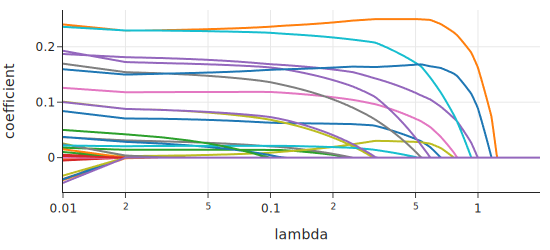

In [235]:
col_names = ["x" + str(v) for v in np.arange(1, 36, 1)]

coefs_df = pd.DataFrame(coefs, columns=col_names)

coefs_df["lambda"] = alphas
coefs_long = pd.melt(coefs_df, id_vars=["lambda"], value_vars=col_names)

fig = px.line(coefs_long, x="lambda", y="value", color="variable", log_x=True)
fig.update_layout(
    showlegend=False, width=550, height=250, yaxis_title="coefficient"
)

As $ \lambda $ increases, the model fitting is penalized more heavily and many coefficients shrink to 0. The left hand side of the plot shows greater model complexity and corresponds to small $ \lambda $. Notice that for $ \lambda = 0.5 $, nearly all of the coefficients are zero. The exceptions are, from largest to smallest: `x12`, `x30`, `x31`, `x5`, `x7`,  `x1`, `x9`,  `x28`, `x20`. 

We can also plot the MSE as a function of $ \lambda $ to see how it changes with the increase in the penalty:

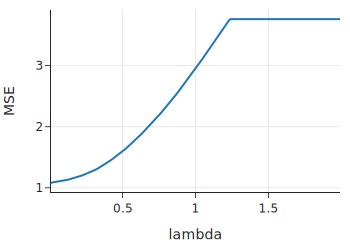

In [236]:
px.line(x=alphas, y=mses,
        labels={"x": "lambda", "y": "MSE"},
        width=350, height=250)

When $ \lambda $ reaches about 1.25, the penalty is so large that the lasso regression is simply fitting a constant model to the data, and the MSE doesn't change. We are again faced with a model selection question, but this time it's in the form of deciding on $ \lambda $. We can use cross-validation to help us. 

We use the `LassoCV` method to perform 5-fold cross-validation to choose $\lambda$:

In [237]:
from sklearn.linear_model import LassoCV

lasso_cv_model = LassoCV(
    alphas=np.arange(0.01, 1, 0.01), cv=5, max_iter=100000
)

Notice that we have specified a maximum number of iterations because the minimization uses numerical optimization (see {numref}`Chapter %s <ch:optimization>`) to solve for the coefficients, and we have placed a cap on the number of iterations to run to reach the specified tolerance for the optimal parameter. We're ready to fit the model on the train set:

In [239]:
lasso_best = lasso_cv_model.fit(X_train_scaled, y_train)

Cross-validation has chosen the following regularization parameter:

In [240]:
lasso_best.alpha_

0.04

Next, let's compute the MSE for predictions in the test set using this cross-validated model: 

In [242]:
y_test_pred = lasso_best.predict(X_test_scaled)
mean_squared_error(y_test, y_test_pred)

1.0957444655340487

Let's find how many coefficients are not 0:

In [243]:
sum(np.abs(lasso_best.coef_) > 0)

16

We next demonstrate how the Ridge regression coefficients change with the penalty. Ridge regression uses an $ L_2 $ penalty, but otherwise the implementation is similar to Lasso regression. As before, we try a range of $ \lambda $ values, and then plot the coefficients to see how they change: 

In [244]:
from sklearn.linear_model import Ridge

coefsR = []
alphasR = np.arange(1, 1001, 25)

for a in alphasR:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train_scaled, y_train)
    coefsR.append(ridge.coef_)

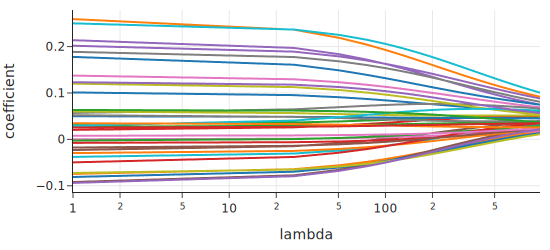

In [245]:
coefsR = np.squeeze(coefsR)

col_names = ["x" + str(v) for v in np.arange(1, 36, 1)]

coefsR_df = pd.DataFrame(coefsR, columns=col_names)
coefsR_df["lambda"] = alphasR

coefsR_long = pd.melt(coefsR_df, id_vars=["lambda"], value_vars=col_names)

fig = px.line(coefsR_long, x="lambda", y="value", color="variable", log_x=True)
fig.update_layout(
    showlegend=False, width=550, height=250, yaxis_title="coefficient"
)
fig.show()

This plot shows a very different shape compared to the lasso coefficient plot. The coefficients do not disappear entirely. The plots do have an important similarity in that as the penalty increases the coefficients shrink.  In a way, with Ridge regression, we are using all of the variables a little bit. For large $ \lambda $, many coefficients, while not 0, are quite small. For example, we can count the number of coefficients larger than 0.05 for $ \lambda = 600 $:

In [246]:
sum(abs(coefsR[24, :]) > 0.05)

13

Similar to lasso, many of the features have tiny coefficients.

Again, to select the best $ \lambda $ we can turn to cross-validation and use `RidgeCV`. We omit the details here because the approach is the same as `LassoCV`.

Using $ L_1 $ or $ L_2 $ regularization, allows us to avoid model over-fitting by penalizing large coefficients.  $ L_1 $ regularization has the advantage of zeroing out coefficients; it performs *feature selection* by discarding the features with a coefficient of 0. This is particularly useful when working with high-dimensional data with many features. A model that only uses a few features to make a prediction runs much faster than a model that requires many calculations. Since unneeded features tend to increase model variance without decreasing bias, we can sometimes increase the accuracy of other models by using lasso regression to select a subset of features to use.

:::{note}

Sometimes we prefer one type of regularization over the other because it maps more closely to the domain we are working with. For example, if we know that the phenomenon we are trying to model results from many small factors, we might prefer ridge regression because it won't discard these factors. On the other hand, some outcomes result from a few highly influential features. We prefer lasso regression in these situations because it discards unneeded features. Both $L_2$ and $L_1$ serve as useful throttles to navigate between under- and over-fitting.

:::

Regularization, train-test split, and cross-validation all have the goal to reduce over-fitting. The problem with over-fitting comes from using data to both fit a model and estimate the model's error in predicting new observations. In the next section, we provide further intuition for this idea.